In [1]:
import numpy as np
import qutip as qt
import scipy.stats as sp
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import random
from ipynb.fs.full.myfunctions import *
import itertools
import time

In [2]:
def sample_ginibre_ensemble(n, p, dim_n, dim_k=None):
    # draw n states from the ginibre distribution (unbiased)
    if dim_k is None: dim_kk = dim_n
    else: dim_kk = dim_k
    x_0 = np.zeros((n, dim_n**2))
    w_0 = np.ones(n)/n
    for i in range(n):
        dm = rand_dm_ginibre(dim_n, dim_kk)
        x_0[i] = dm_to_bvector(dm, p, dim_n) # calculate pauli representation
    return x_0, w_0

def experiment(rho, c):
    # measure rho pauli basises specified in c
    if(len(rho) != 4 ** len(c[0])): print("wrong dimensions!")
    q = len(c[0])
    data = np.zeros(c.shape)
    a = np.array([list(i) for i in itertools.product([0, 1], repeat=q)]) # possible measurement outcomes
    ind = np.array([4**i for i in range(q)][::-1])
    for idc, ci in enumerate(c):
        probs = np.zeros(len(a))
        for ida, ai in enumerate(a): # loop over possible outcomes
            for bi in a: # loop over all involved measurements
                probs[ida] += (-1)**(np.sum(bi*ai))*rho[int(np.sum(ci * ind * bi))]
        data[idc] = a[np.random.choice(range(len(a)), p = probs)]
    return data
    
def likelihood(x, d, c):
    # calculate likelihood of measurement outcome d given that the state is x
    lh = np.zeros(len(x))
    ind = np.array([4**i for i in range(len(c))][::-1])
    b = np.array([list(i) for i in itertools.product([0, 1], repeat=len(c))])
    for idx, xi in enumerate(x):
        for bi in b:
            lh[idx] += (-1)**(np.sum(bi*d))*xi[int(np.sum(c * ind * bi))]
    return lh

def bayes_update(x, w, d, c, n_active, threshold):
    # update weights according to likelihood and normalize
    w_temp = w
    start = time.time()
    for i in range(len(c)):
        w_new = np.zeros(len(w_temp))
        w_new[n_active] = w_temp[n_active] * likelihood(x[n_active], d[i], c[i])
        w_new[n_active] = np.divide(w_new[n_active], np.sum(w_new[n_active]))
        w_temp = w_new
        n_active = n_active[np.where(w_temp[n_active] > threshold)]
    end = time.time()
    return w_temp, end-start

def pointestimate(x, w):
    # return point estimate of rho
    return np.average(x, axis=0, weights= w)

def fidelity(a, b, p):
    # compute fidelity from density matrices in Pauli representation
    return qt.metrics.fidelity(bvector_to_dm(a, p), bvector_to_dm(b, p))**2

In [148]:
n_q = 4 # number of Qubits - fixed in this implementation
dim = 2**n_q # dimension of Hilbert space
p = create_pauli_basis(n_q) # create Pauli basis

# experiment in Pauli basis
n_meas = 64 # number of measurements
c_meas = np.random.randint(1, 4, size= (n_meas, n_q)) # create pauli measurement basis (1=x, 2=y, 3=z)

# sampling
n = 1000 # number of sampling points

# cut_off
threshold = 1 / (n**2)
n_active0 = np.arange(n)

In [149]:
x, w0 = sample_ginibre_ensemble(n, p, dim, dim) # Generate particle cloud unbiased prior
rho = x[0] # Ideal state
d_meas = experiment(rho, c_meas) # Experiments

# Update the weights of the point cloud
w, dt = bayes_update(x, w0, d_meas, c_meas, n_active0, threshold)

# Estimates
rho_est = pointestimate(x, w)
print(fidelity(rho, rho_est, p))
print(dt)

In [153]:
### RISK ###

n_q = [1, 2, 3, 4] # number of Qubits - fixed in this implementation

# experiment in Pauli basis
n_meas = [1, 4, 16, 64] # number of measurements
meas_rep = 20 # number of repetition

# sampling number
n = 1000
rep_prep = 20

# cut off
threshold = 1 / n**2
n_active0 = np.arange(n)

# output
fid = np.zeros((len(n_q), len(n_meas), rep_prep, meas_rep))
t = np.zeros((len(n_q), len(n_meas), rep_prep, meas_rep))
n_ess = np.zeros((len(n_q), len(n_meas), rep_prep, meas_rep))
w_rho = np.zeros((len(n_q), len(n_meas), rep_prep, meas_rep))

In [154]:
for iq, q in enumerate(n_q):
    print(q)
    dim = 2 ** q
    p = create_pauli_basis(q)
    c_meas = np.random.randint(1, 4, size= (meas_rep, n_meas[-1], q)) # create pauli measurement basis (1=x, 2=y, 3=z)
    x, w0 = sample_ginibre_ensemble(n, p, dim, dim)
    for i in range(rep_prep):
        rho = x[i]
        for j in range(meas_rep):
            d_meas = experiment(rho, c_meas[j]) # Experiments
            for idk, k in enumerate(n_meas):
                w, dt = bayes_update(x, w0, d_meas[:k], c_meas[j][:k], n_active0, threshold)
                fid[iq][idk][i][j] = np.round(fidelity(rho, pointestimate(x, w), p), decimals= 7)
                t[iq][idk][i][j] = np.round(dt, decimals= 3)
                n_ess[iq][idk][i][j] = np.round(1 / np.sum(w**2), decimals= 4)
                w_rho[iq][idk][i][j] = np.round(np.max(w), decimals= 4)

1
2
3
4


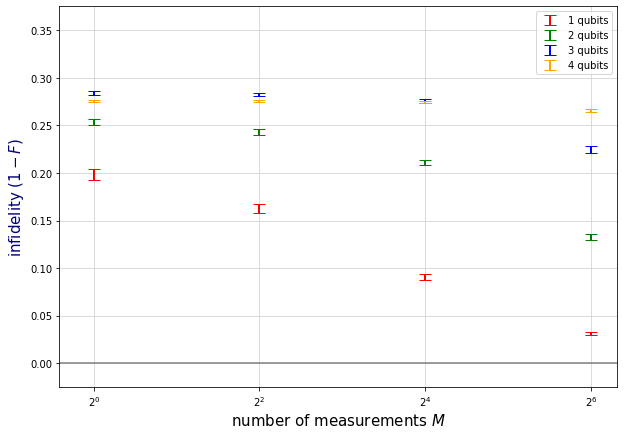

In [158]:
fid_avg = np.average(1 - fid, axis= (2, 3))
fid_8_total = np.std(1 - fid, axis= (2, 3)) / np.sqrt(rep_prep * meas_rep)

t_avg = np.average(t, axis=(2, 3))
t_8_total = np.std(t, axis= (2, 3)) / np.sqrt(rep_prep * meas_rep)

# Plot fidelities
fig, ax1 = plt.subplots(figsize=(10, 7))

color = ['red', 'green', 'blue', 'orange']

m_s = 8                      
for indq, qi in enumerate(n_q):
    ax1.errorbar(n_meas, fid_avg[indq], yerr= fid_8_total[indq], c= color[indq], ls= '-', marker= 'o', ms= 0, lw= 0, capsize=6, elinewidth=2, label= str(qi) + ' qubits')    

fs = 15
ax1.axhline(0, c= 'gray')
ax1.legend()
ax1.set_xscale('log', base=2)
ax1.set_xlim(0.75, 80)
ax1.set_xlabel(r'number of measurements $M$', fontsize=fs)
ax1.set_xticks([1, 4, 16, 64], fontsize=fs)
ax1.set_ylabel(r'infidelity ($1-F$)', fontsize=fs, c= 'navy')
ax1.set_yticks(np.linspace(0, 0.35, 8), fontsize=fs)
ax1.set_ylim(-0.025, 0.375)
ax1.grid()

plt.grid(c='lightgray')
plt.show()